## Thoai Nguyen's Zillow MVP Presentation

Goals :  use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt

Predict values of single unit properties that the tax distict assess using the property data from those whose last transaction was during 2017

Obtain tax rates(new feature) for each county

Confirm Hypothesis of potential Key Drivers

    There is not a linear correlation between square footage of home and tax value.

    There is not a linear correlation between bedrooms and tax value.

    There is not a linear correlation between bathrooms and tax value.

   

In [1]:
%autosave 0

Autosave disabled


In [2]:
## python files that contain the functions to aquire and prep the data
import wrangle
import explore
import model
import pandas as pd
import numpy as np

from wrangle import Properties_Per_county
from model import county_taxrate_distribution, mvp_scatter
from explore import mvp_columns_keep

# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from env import get_connection
import math

# scikit learn
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

#visulization settings
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.style as style 
style.available
style.use('seaborn-talk')
style.use('seaborn-colorblind')

#warnings
import warnings
warnings.filterwarnings("ignore")

# Data Summary

In [3]:
df = wrangle.clean_zillow(wrangle.get_zillow_data())
df.head()

,bedrooms,bathrooms,yearbuilt,county,zip_code,fips,latitude,longitude,square_feet,taxamount,tax_value,property_age,tax_rate
parcelid,,,,,,,,,,,,,
14297519,4,3.5,1998,1286,96978,6059,33634931,-117869207,3100.0,11013.72,1023282.0,23,0.010763
17052889,2,1.0,1967,2061,97099,6111,34449266,-119281531,1465.0,5672.48,464000.0,54,0.012225
14186244,3,2.0,1962,1286,97078,6059,33886168,-117823170,1243.0,6488.30,564778.0,59,0.011488
12177905,4,3.0,1970,3101,96330,6037,34245180,-118240722,2376.0,1777.51,145143.0,51,0.012247
10887214,3,3.0,1964,3101,96451,6037,34185120,-118414640,1312.0,1533.89,119407.0,57,0.012846


In [4]:
df.describe()

,bedrooms,bathrooms,yearbuilt,county,zip_code,fips,latitude,longitude,square_feet,taxamount,tax_value,property_age,tax_rate
count,77252.000000,77252.000000,77252.000000,77252.000000,77252.000000,77252.000000,7.725200e+04,7.725200e+04,77252.000000,77252.000000,7.725200e+04,77252.000000,77252.000000
mean,3.061151,2.304257,1968.598910,2535.851590,96586.485308,6048.770414,3.400856e+07,-1.182035e+08,1784.137071,5977.964178,4.886553e+05,52.401090,0.013167
std,1.129847,0.990174,23.786378,801.103519,3800.252247,20.707293,2.652612e+05,3.588724e+05,953.270485,7576.193460,6.499171e+05,23.786378,0.005758
min,0.000000,0.000000,1824.000000,1286.000000,95982.000000,6037.000000,3.333953e+07,-1.194753e+08,128.000000,19.920000,1.000000e+03,5.000000,0.000094
25%,2.000000,2.000000,1953.000000,1286.000000,96193.000000,6037.000000,3.381480e+07,-1.184150e+08,1182.000000,2714.877500,2.070000e+05,34.000000,0.011662
50%,3.000000,2.000000,1970.000000,3101.000000,96389.000000,6037.000000,3.402211e+07,-1.181809e+08,1541.000000,4447.620000,3.587820e+05,51.000000,0.012286
75%,4.000000,3.000000,1987.000000,3101.000000,96987.000000,6059.000000,3.417437e+07,-1.179290e+08,2110.000000,6920.750000,5.685390e+05,68.000000,0.013455
max,16.000000,18.000000,2016.000000,3101.000000,399675.000000,6111.000000,3.481877e+07,-1.175546e+08,35640.000000,586639.300000,4.906124e+07,197.000000,0.816490


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77252 entries, 14297519 to 12826780
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      77252 non-null  int64  
 1   bathrooms     77252 non-null  float64
 2   yearbuilt     77252 non-null  int64  
 3   county        77252 non-null  int64  
 4   zip_code      77252 non-null  int64  
 5   fips          77252 non-null  int64  
 6   latitude      77252 non-null  int64  
 7   longitude     77252 non-null  int64  
 8   square_feet   77252 non-null  float64
 9   taxamount     77252 non-null  float64
 10  tax_value     77252 non-null  float64
 11  property_age  77252 non-null  int64  
 12  tax_rate      77252 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 8.3 MB


In [6]:
df.shape

(77252, 13)

# Is fips the key driver?

In [7]:
df.fips.value_counts()
df.fips.value_counts(normalize=True)


6037    0.654404
6059    0.265456
6111    0.080140
Name: fips, dtype: float64

There are three fibs with their respective location

Los Angeles, California (6037)

Orange, California (6059)

Ventura, California (6111)

In [8]:
#Change fips to county names now that we know where they come from
df['fips'] = df['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})


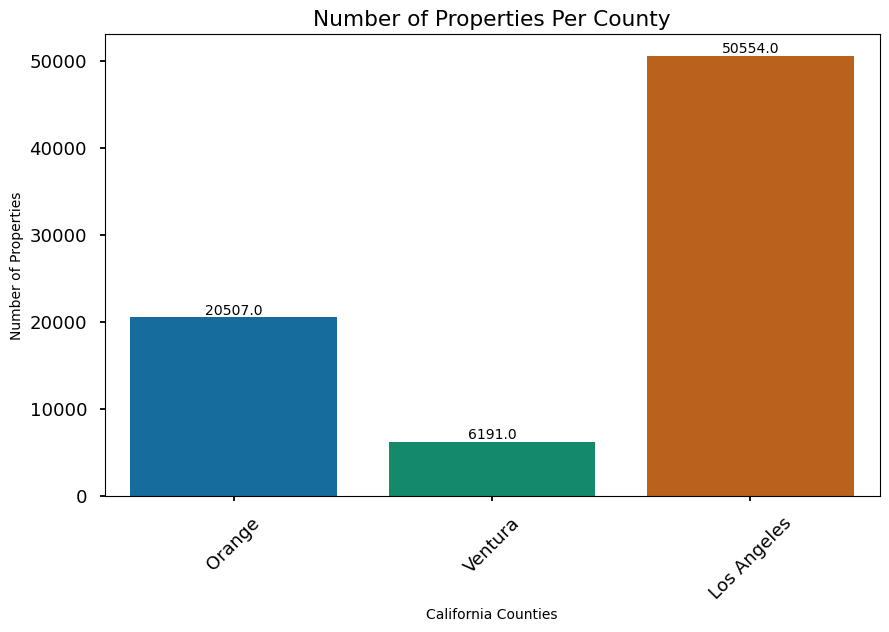

In [9]:

# Property counts per county
Properties_Per_county(df)

There are more number of properties reside in Los Angeles.

## How does tax work in each county ?

In [10]:
tax_rates = df.groupby("fips").tax_rate.mean()
tax_rates 

fips
Los Angeles    0.013768
Orange         0.012064
Ventura        0.011912
Name: tax_rate, dtype: float64

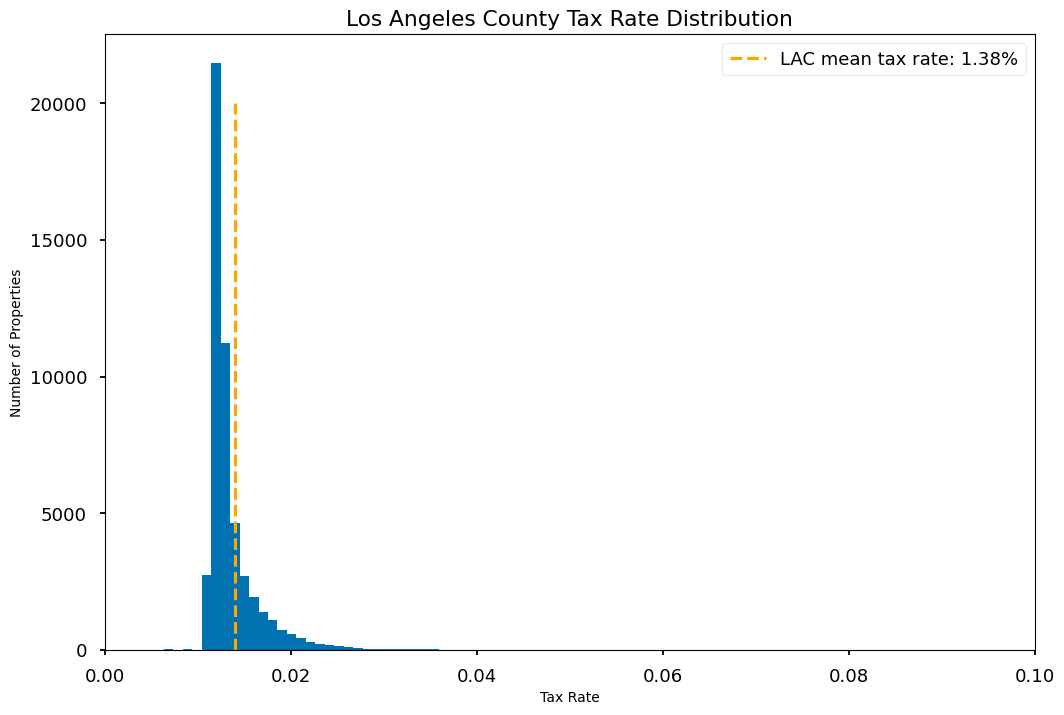

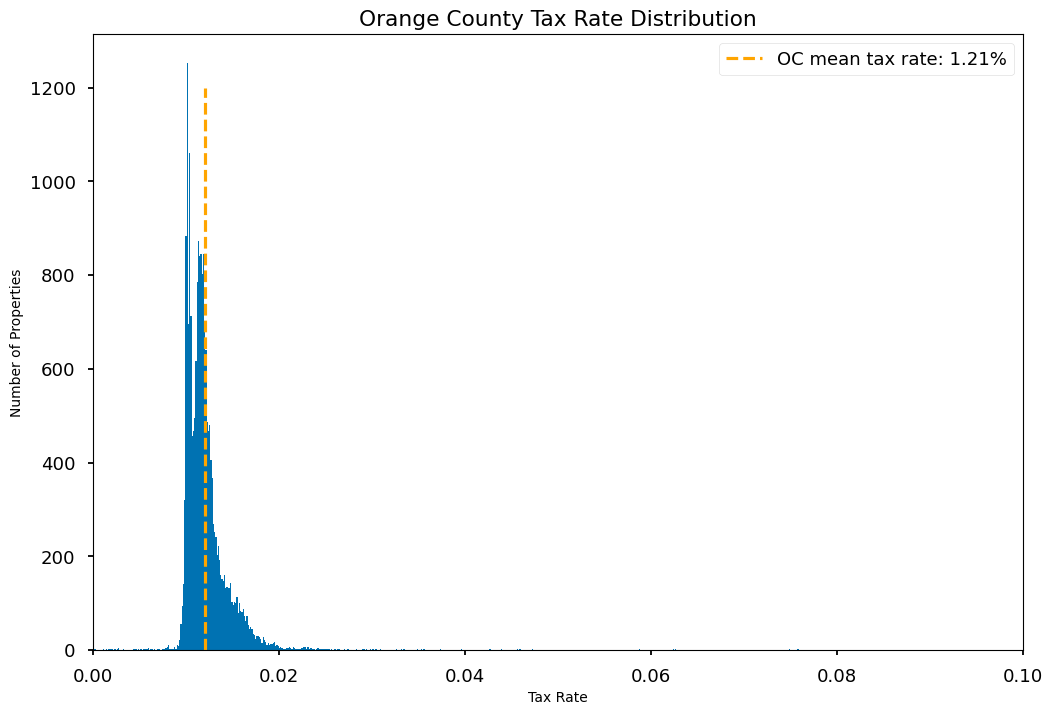

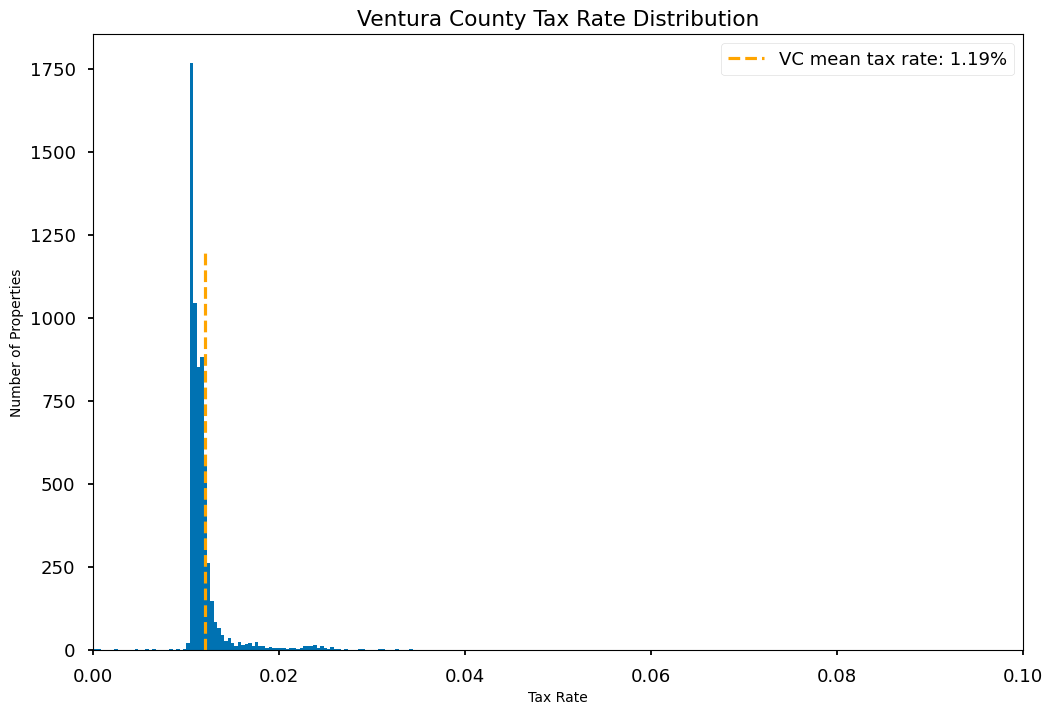

In [11]:
# County Tax Rate Distribution
county_taxrate_distribution(df)

we like to see the central tendency of the tax rate showing majority of the properties are paying lower taxes. Something that make sense


# MPV

In [12]:
mvp = df.copy()
mvp.head()

,bedrooms,bathrooms,yearbuilt,county,zip_code,fips,latitude,longitude,square_feet,taxamount,tax_value,property_age,tax_rate
parcelid,,,,,,,,,,,,,
14297519,4,3.5,1998,1286,96978,Orange,33634931,-117869207,3100.0,11013.72,1023282.0,23,0.010763
17052889,2,1.0,1967,2061,97099,Ventura,34449266,-119281531,1465.0,5672.48,464000.0,54,0.012225
14186244,3,2.0,1962,1286,97078,Orange,33886168,-117823170,1243.0,6488.30,564778.0,59,0.011488
12177905,4,3.0,1970,3101,96330,Los Angeles,34245180,-118240722,2376.0,1777.51,145143.0,51,0.012247
10887214,3,3.0,1964,3101,96451,Los Angeles,34185120,-118414640,1312.0,1533.89,119407.0,57,0.012846


In [13]:
mvp.drop(['yearbuilt', 'county', 'zip_code', 'fips', 'latitude','longitude', 'taxamount', 'property_age', 'tax_rate'], axis=1, inplace=True)


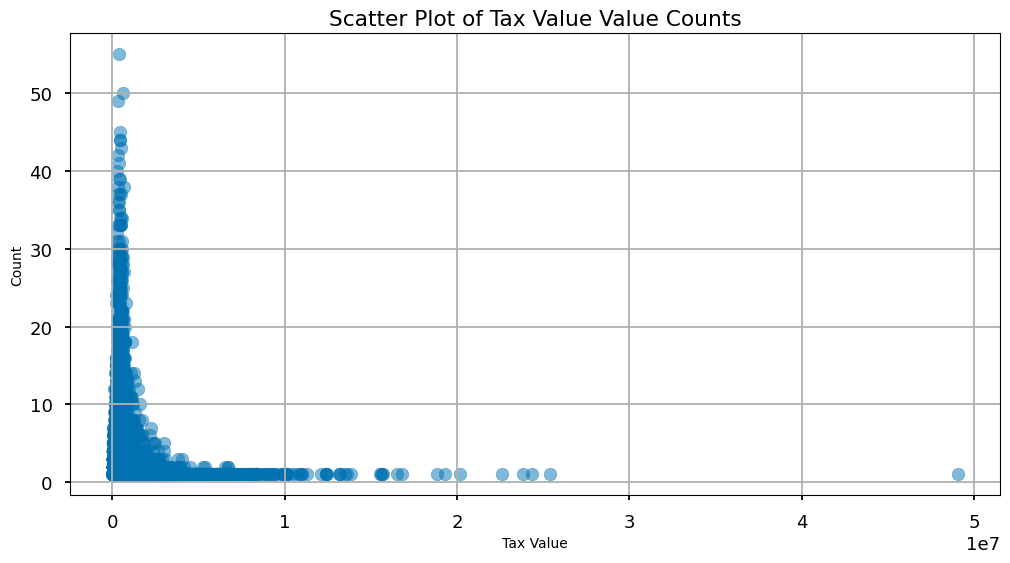

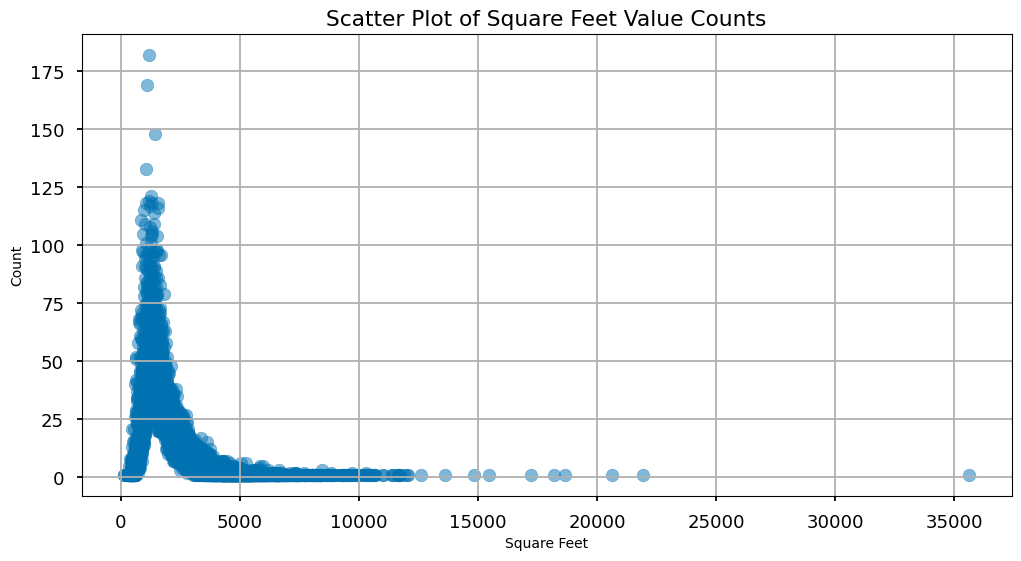

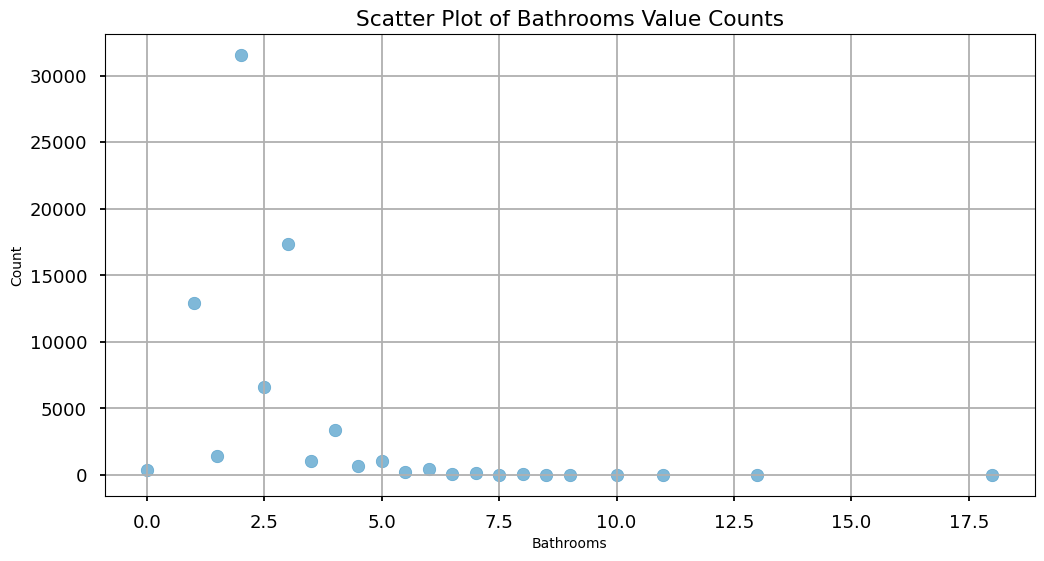

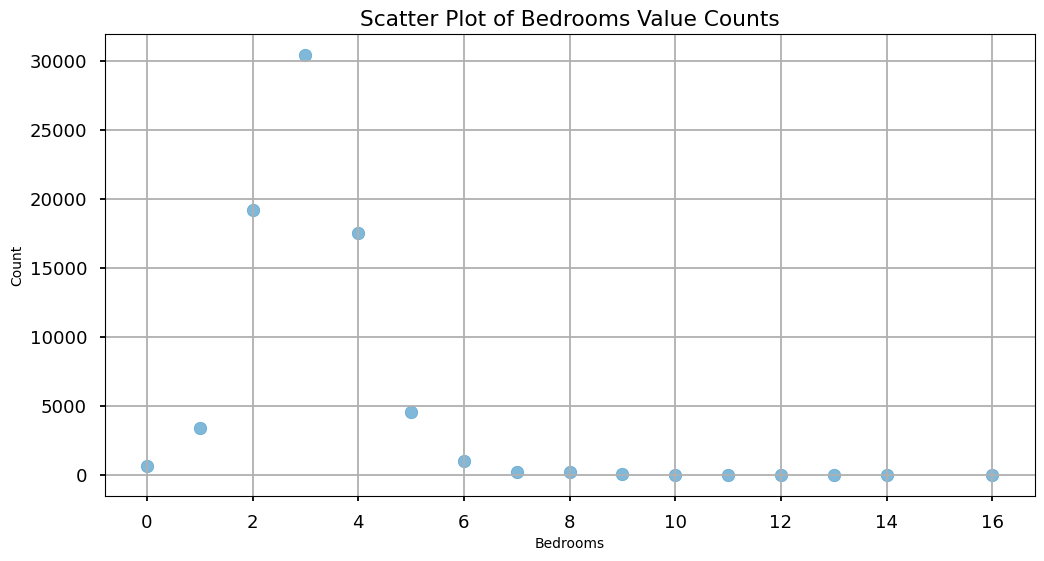

In [14]:
# Scatter data with tax_value, Square Feet, bedroom, and bathroom
mvp_scatter(df)


### MVP prep takeaway:

All chosen features have outliers and the data is being skewed by really expensive houses. 

### Clean and Prep 

renamed necessary columns, change necessary datatypes, 

### Visualize Univariates

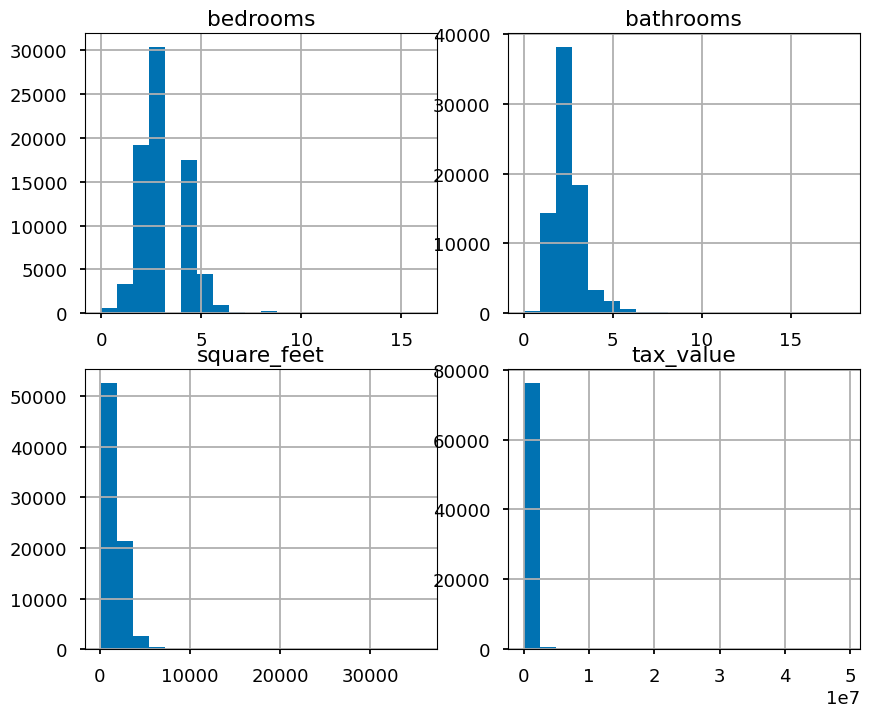

In [15]:
#Visualiing univariates data between the 4 variables
def visualize_univariates():
    plt.figure(figsize=(10, 8))
    for i, col in enumerate(['bedrooms', 'bathrooms', 'square_feet', 'tax_value']):  
        plot_number = i + 1 # i starts at 0, but plot nos should start at 1
        series = df[col]  
        plt.subplot(2,2, plot_number)
        plt.title(col)
        series.hist(bins=20)
visualize_univariates()

Bedroms are normally distributed in comparison to bathrooms being skewed to the right. So is square_feet and tax_value

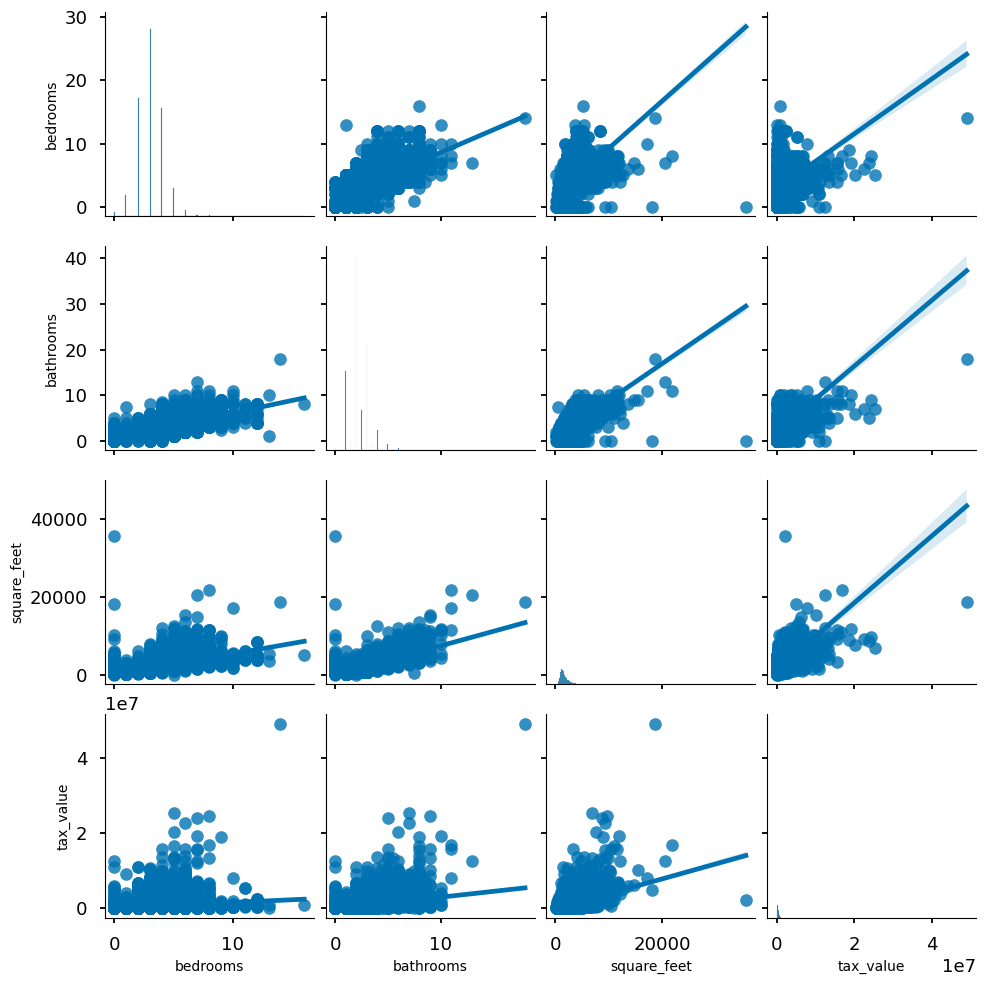

In [16]:

def mvp_pairplot():
    sns.pairplot(mvp,
                x_vars=["bedrooms", "bathrooms", "square_feet", 'tax_value'],
                y_vars=["bedrooms", "bathrooms", "square_feet", 'tax_value'],
                kind= "reg")
mvp_pairplot()


The bigger the square_feetthe biggerthe bath and bedrooms

The more the tax_value the more square_feet, bathrooms, and bedrooms

From this I will use the correlation test to confirm my hypotheses

But first I will split my dataset and scale numerical features

### MVP Explore

In [17]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test_split(mvp,'tax_value', 123)
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (43260, 4)
validate -> (18541, 4)
test -> (15451, 4)


In [18]:
mvp_columns_keep(mvp)

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
14297519,4,3.5,3100.0,1023282.0
17052889,2,1.0,1465.0,464000.0
14186244,3,2.0,1243.0,564778.0
12177905,4,3.0,2376.0,145143.0
10887214,3,3.0,1312.0,119407.0
...,...,...,...,...
10833991,3,3.0,1741.0,379000.0
11000655,2,2.0,1286.0,354621.0
17239384,4,2.0,1612.0,67205.0


#### Scale all numeric feature to normalize 

In [19]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.Standard_Scaler(X_train, X_validate, X_test)



In [20]:
X_train_scaled.head()


,bedrooms,bathrooms,square_feet
parcelid,,,
17228134,-0.052499,-0.309698,0.107487
11322311,-0.052499,0.698774,1.386685
17153382,-0.935503,-0.309698,0.159418
14682419,-0.052499,0.698774,-0.276167
13941783,-0.052499,-1.318170,2.748548


### Statistical Tests

Correlations

## Hypothesis 1:
Hypothesis = there is no correlation between the square feet and tax value

Alternative = there is a correlation between square feet and tax value

In [21]:
def mvp_hypothesis_1(train, alpha=0.05):
    # Calculate Pearson's correlation coefficient
    corr, p = stats.pearsonr(train.square_feet, train.tax_value)
    print(f'Correlation for square feet is: {corr} and p value is: {p}')

    # Correlation test summary
    if p < alpha:
        print(f'P-value is: {p} which is less than alpha: {alpha}')
        print("Reject the null hypothesis")
    else:
        print(f'P-value is: {p} which is greater than alpha: {alpha}')
        print("We fail to reject the null hypothesis")
mvp_hypothesis_1(df)

Correlation for square feet is: 0.5836301505862757 and p value is: 0.0
P-value is: 0.0 which is less than alpha: 0.05
Reject the null hypothesis


## Hypothesis 2:

Null = There is no correlation between bathrooms and tax value 

Alternative = There is a correlation between bathrooms and tax value

In [76]:
alpha = 0.05
#calculate pearsons correlation coefficient
corr, p = stats.pearsonr(train.bathrooms, train.tax_value)
corr, p
print(f'Correlation for bathrooms is: {corr} and p value is: {p}')

#correlation test summary
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis")

Correlation for bathrooms is: 0.41185277906726725 and p value is: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis


## Hypothesis 3:

Null = There are no correlation between bedrooms and tax_value

Alternative = There is a correlation between the bedrooms and tax_value

In [77]:
#calculate pearsons correlation coefficient
corr, p = stats.pearsonr(train.square_feet, train.tax_value)
corr, p
print(f'Correlation for bedrooms is: {corr} and p value is: {p}')

#correlation test summary
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis")


Correlation for bedrooms is: 0.4992764511050193 and p value is: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis


If i don't have time to identify the key driver for home tax value, I will state at the very least we were able to conclude that square feet has a correlation with tax value, bedroom, and bathroom.

# Modeling

In [23]:
X_train_scaled.head()


,bedrooms,bathrooms,square_feet
parcelid,,,
17228134,-0.052499,-0.309698,0.107487
11322311,-0.052499,0.698774,1.386685
17153382,-0.935503,-0.309698,0.159418
14682419,-0.052499,0.698774,-0.276167
13941783,-0.052499,-1.318170,2.748548


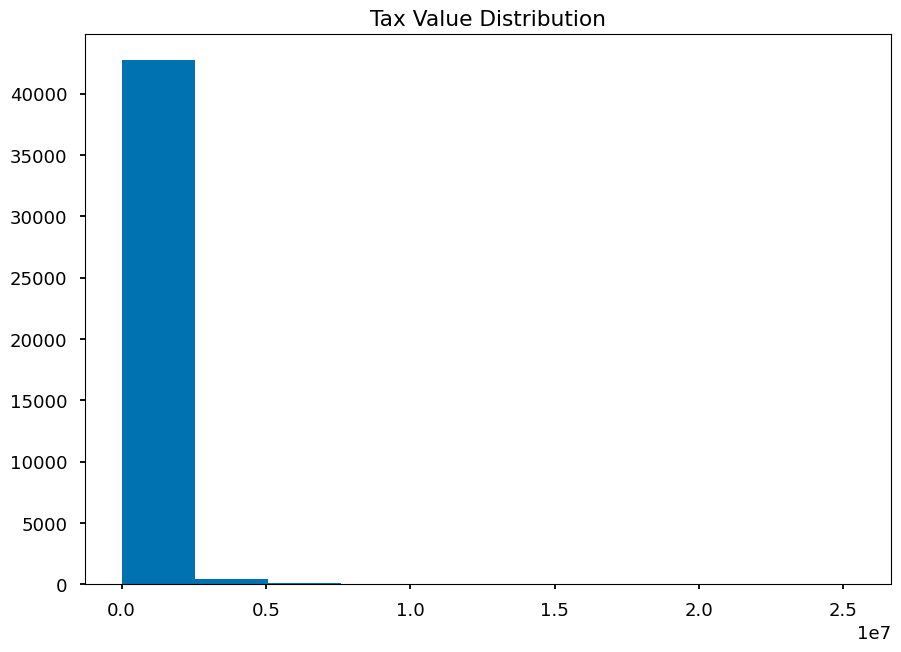

In [24]:
# see distribution?
plt.hist(y_train)
plt.title('Tax Value Distribution')
plt.show()

In [26]:
X_train.shape, X_train_scaled.shape, y_train.shape, X_validate.shape, X_validate_scaled.shape, y_validate.shape, X_test.shape, X_test_scaled.shape, y_test.shape


((43260, 3),
 (43260, 3),
 (43260,),
 (18541, 3),
 (18541, 3),
 (18541,),
 (15451, 3),
 (15451, 3),
 (15451,))

In [27]:
#Create a Handy DataFrame for Evaluating Your Models or Model and Baseline Value.
#turn series into df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

,tax_value
parcelid,
17228134,246735.0
11322311,349000.0
17153382,540544.0
14682419,630000.0
13941783,444538.0


### Baseline

In [28]:
# predict the median for ytrain and yvalidate
baseline_median = y_train['tax_value'].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median

#predict the mean for ytrain and yvalidate
baseline_mean = y_train['tax_value'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean
y_train.head()

,tax_value,baseline_median,baseline_mean
parcelid,,,
17228134,246735.0,359907.5,490082.010888
11322311,349000.0,359907.5,490082.010888
17153382,540544.0,359907.5,490082.010888
14682419,630000.0,359907.5,490082.010888
13941783,444538.0,359907.5,490082.010888


### Should I use mean or median? 

In [29]:
#Evaluate the baseline model using the mean
model.baseline_mean_errors(y_train.tax_value)

#Evaluate the baseline model using the median
model.baseline_median_errors(y_train.tax_value)

# RMSE of pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# RMSE of pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  632703.83 
Validate/Out-of-Sample:  738506.92
RMSE using Median
Train/In-Sample:  645956.3 
Validate/Out-of-Sample:  750360.66


Chat GPT said since I am concerned about outliers, I do want to utilize the median as my baseline

## Train and Validate with the models

### Linear Regression

In [30]:
lm = LinearRegression()
lm.fit(X_train, y_train.tax_value)

LinearRegression()

In [31]:
y_train['pred_lm'] = lm.predict(X_train)
y_train

,tax_value,baseline_median,baseline_mean,pred_lm
parcelid,,,,
17228134,246735.0,359907.5,490082.010888,5.226829e+05
11322311,349000.0,359907.5,490082.010888,1.130961e+06
17153382,540544.0,359907.5,490082.010888,6.814932e+05
14682419,630000.0,359907.5,490082.010888,4.288187e+05
13941783,444538.0,359907.5,490082.010888,1.569742e+06
...,...,...,...,...
11993657,491259.0,359907.5,490082.010888,4.887849e+05
14346543,371880.0,359907.5,490082.010888,5.084746e+05
14306263,718578.0,359907.5,490082.010888,3.660546e+05


In [32]:
rmse_train_lm = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(0.5)
y_validate['pred_lm'] = lm.predict(X_validate)
rmse_validate_lm = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(0.5)
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 645956.3
Validate/Out-of-Sample: 750360.66
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 495735.23
Validation/Out-of-Sample: 601004.39



### LassoLars

In [33]:
lars = LassoLars(alpha=1.0)
lars.fit(X_train, y_train.tax_value)

LassoLars()

In [34]:
y_train['pred_lars'] = lars.predict(X_train)
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(0.5)
y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate_lars = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(0.5)
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 645956.3
Validate/Out-of-Sample: 750360.66
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 495735.23
Validation/Out-of-Sample: 601004.39
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 495735.23
Validation/Out-of-Sample: 601004.5



### Tweedie Regressor

In [35]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train, y_train.tax_value)

TweedieRegressor(alpha=0, power=1)

In [36]:
y_train['pred_glm'] = glm.predict(X_train)
rmse_train_glm = mean_squared_error(y_train.tax_value, y_train.pred_glm)**(0.5)
y_validate['pred_glm'] = glm.predict(X_validate)
rmse_validate_glm = mean_squared_error(y_validate.tax_value, y_validate.pred_glm)**(0.5)
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: {round(rmse_train_glm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 645956.3
Validate/Out-of-Sample: 750360.66
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 495735.23
Validation/Out-of-Sample: 601004.39
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 495735.23
Validation/Out-of-Sample: 601004.5
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: 632703.83
Validation/Out-of-Sample: 738506.92



### Polynomial Regression  **

In [82]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [91]:
# create the model object on linear square 
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.tax_value, y_train.pred_lm2)**(0.5)

# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2)**(0.5)
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: {round(rmse_train_glm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: {round(rmse_train_lm2, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}

''')                                       
                                       
                                       


BASELINE:
              
RMSE using Median
Train/In-Sample: 260351.52
Validate/Out-of-Sample: 261943.44
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 212676.0
Validation/Out-of-Sample: 213730.37
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 212671.61
Validation/Out-of-Sample: 213741.46
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: 255963.82
Validation/Out-of-Sample: 257222.1
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: 200976.36
Validation/Out-of-Sample: 203874.82




## Evaluate

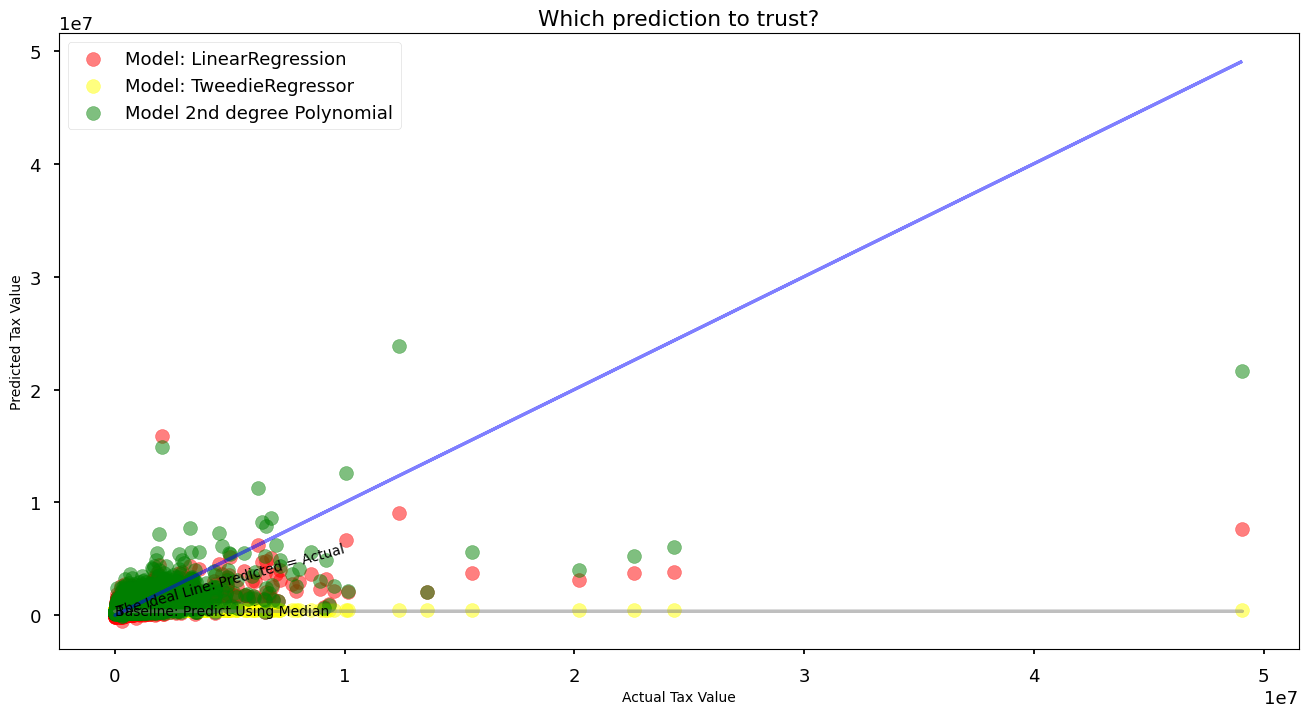

In [39]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_median, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Median", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Which prediction to trust?")
plt.show()

In [88]:
metric_df = pd.DataFrame(data=[{
    'model': 'median_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.baseline_median)}])

metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm)}, ignore_index=True)


metric_df = metric_df.append({
    'model': 'GLS (Poisson)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_glm)}, ignore_index=True)


metric_df = metric_df.append({
    'model': 'Linear Regression', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm2)}, ignore_index=True)


In [89]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,261943.442150,2.220446e-16
1,OLS Regressor,213730.369311,3.095704e-01
2,GLS (Poisson),257222.102045,2.220446e-16
3,Linear Regression,203874.816062,3.717769e-01


In [90]:
#possible percentage value on r2

## Test

Based on the provided data, the "Quadratic Model" has the lowest RMSE and the highest R-squared value on the validation dataset. This suggests that the "Quadratic Model" performed the best among the listed models on the validation data.

In [87]:

y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm2)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
    
Test/Out-of-Sample Performance: {rmse_test}
""")


RMSE for Polynomial Regressor, degrees=2:
    
Test/Out-of-Sample Performance: 202864.84707069927



# --------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------

# MORE DATA TO TEST

Conclusion: 

    I was able to confirm the that square feet, bathrooms, and bedrooms have a significant correlation with tax_value
    
    With more time I would like to gather more data without outlier for testing
    

In [43]:
df = wrangle.clean_zillow(wrangle.get_zillow_data())
df.describe()


,bedrooms,bathrooms,yearbuilt,county,zip_code,fips,latitude,longitude,square_feet,taxamount,tax_value,property_age,tax_rate
count,77252.000000,77252.000000,77252.000000,77252.000000,77252.000000,77252.000000,7.725200e+04,7.725200e+04,77252.000000,77252.000000,7.725200e+04,77252.000000,77252.000000
mean,3.061151,2.304257,1968.598910,2535.851590,96586.485308,6048.770414,3.400856e+07,-1.182035e+08,1784.137071,5977.964178,4.886553e+05,52.401090,0.013167
std,1.129847,0.990174,23.786378,801.103519,3800.252247,20.707293,2.652612e+05,3.588724e+05,953.270485,7576.193460,6.499171e+05,23.786378,0.005758
min,0.000000,0.000000,1824.000000,1286.000000,95982.000000,6037.000000,3.333953e+07,-1.194753e+08,128.000000,19.920000,1.000000e+03,5.000000,0.000094
25%,2.000000,2.000000,1953.000000,1286.000000,96193.000000,6037.000000,3.381480e+07,-1.184150e+08,1182.000000,2714.877500,2.070000e+05,34.000000,0.011662
50%,3.000000,2.000000,1970.000000,3101.000000,96389.000000,6037.000000,3.402211e+07,-1.181809e+08,1541.000000,4447.620000,3.587820e+05,51.000000,0.012286
75%,4.000000,3.000000,1987.000000,3101.000000,96987.000000,6059.000000,3.417437e+07,-1.179290e+08,2110.000000,6920.750000,5.685390e+05,68.000000,0.013455
max,16.000000,18.000000,2016.000000,3101.000000,399675.000000,6111.000000,3.481877e+07,-1.175546e+08,35640.000000,586639.300000,4.906124e+07,197.000000,0.816490


In [44]:
#handle outliers
columns = ['bedrooms', 'bathrooms','square_feet', 'tax_value']
for x in columns:
    
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = (Q3 - Q1) * 1.5
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df = df[df[x] < (upper)]
    
    print('column:', x,'\nIQR:', IQR, '\nUpper bound:', upper, '\nLower bound:', lower, '\n')

column: bedrooms 
IQR: 3.0 
Upper bound: 8.5 
Lower bound: -2.5 

column: bathrooms 
IQR: 1.5 
Upper bound: 5.25 
Lower bound: -0.25 

column: square_feet 
IQR: 1350.0 
Upper bound: 4102.0 
Lower bound: -848.0 

column: tax_value 
IQR: 514937.625 
Upper bound: 1318103.9375 
Lower bound: -570000.6875 



In [45]:
#features that will be dropped for this iteration
df.drop(['county', 'zip_code', 'latitude', 'longitude', 'taxamount'], axis=1, inplace=True)


In [46]:
#change fips to object so it doesnt get scaled later
df['fips'] = df['fips'].astype(object)

In [47]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test_split(df,'tax_value', 123)


In [48]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (40673, 8)
validate -> (17432, 8)
test -> (14527, 8)


In [49]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.Standard_Scaler(X_train, X_validate, X_test)


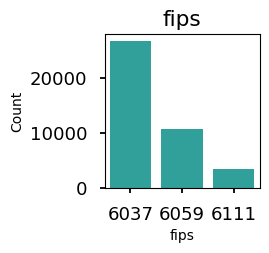

      fips  Count  Percent
6037  6037  26583    65.36
6059  6059  10739    26.40
6111  6111   3351     8.24
_________________________________________________________________


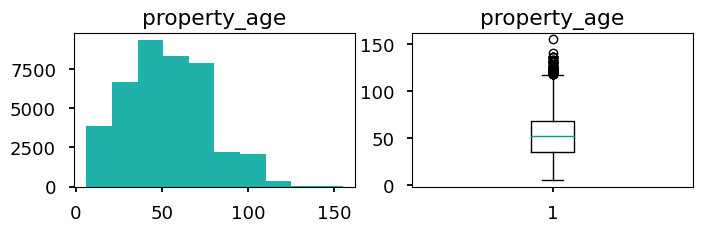

count    40673.000000
mean        52.736951
std         23.346638
min          6.000000
25%         35.000000
50%         52.000000
75%         68.000000
max        155.000000
Name: property_age, dtype: float64


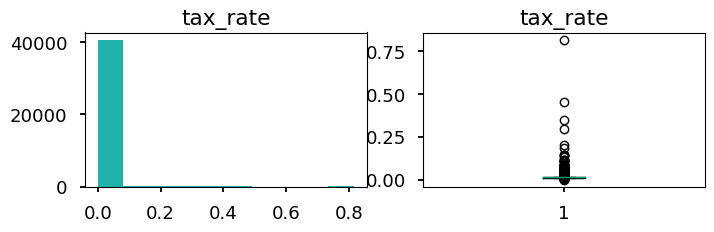

count    40673.000000
mean         0.013265
std          0.006467
min          0.000094
25%          0.011730
50%          0.012336
75%          0.013568
max          0.816490
Name: tax_rate, dtype: float64


In [50]:
cat_vars = ['fips']
quant_vars = ['property_age', 'tax_rate']
explore.explore_univariate(train, cat_vars, quant_vars)

Text(0.5, 1.0, 'Distribution of Tax Rates')

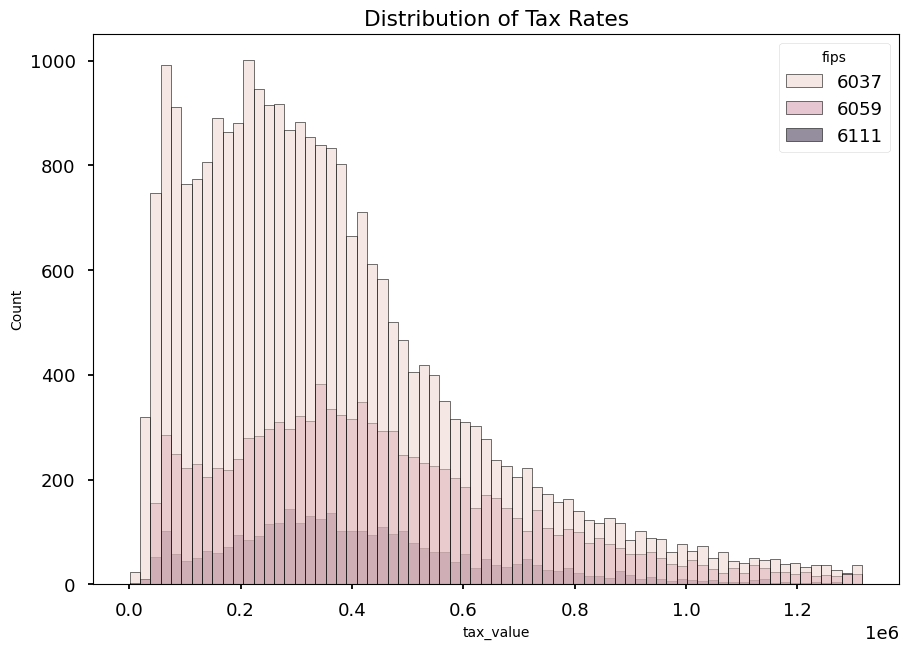

In [51]:
sns.histplot(data=train, x="tax_value", hue = 'fips')
plt.title('Distribution of Tax Rates')

Text(0.5, 1.0, 'Distribution of Tax Rates across Property Age')

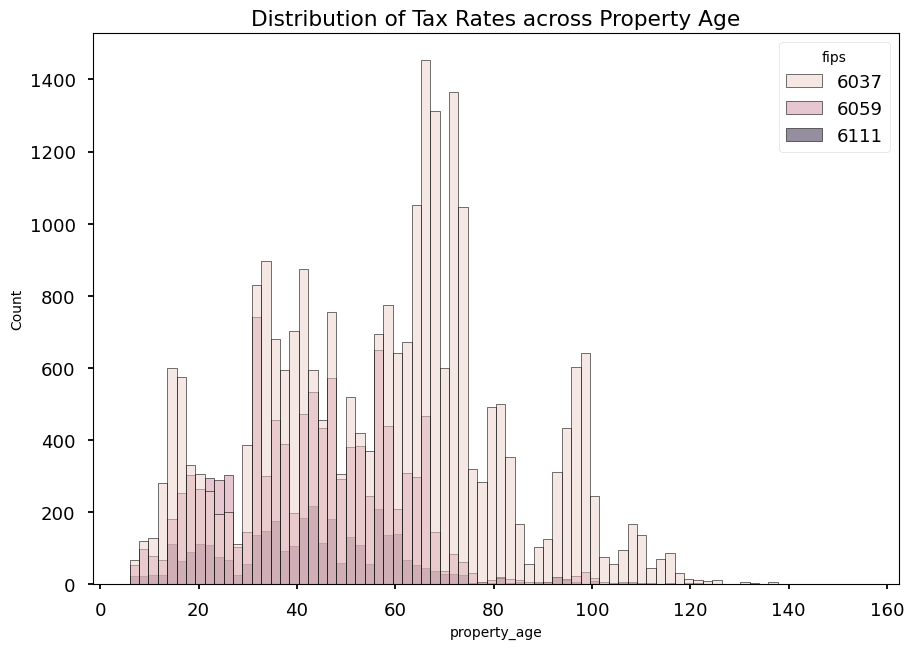

In [52]:
sns.histplot(data=train, x="property_age", hue = 'fips')
plt.title('Distribution of Tax Rates across Property Age')

In [53]:
alpha = .05

Test 1 (corr):¶
Null Hypothesis (HO) = there is no difference between the mean tax values of los angeles and orange county
Alternative Hypothesis (HA) = there is a difference between the mean tax values of los angeles and orange county


In [54]:
la = train[train.fips == 6037]
oc = train[train.fips == 6059]

In [55]:
t, p = stats.ttest_ind(la.tax_value, oc.tax_value)
t, p


(-27.009307665125046, 3.9163768523817306e-159)

In [56]:
#correlation test summary
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

Pvalue is: 3.9163768523817306e-159 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


In [57]:
def select_kbest(x, y, k):
    
    # parameters: f_regression stats test, give me  features
    f_selector = SelectKBest(f_regression, k=k)
    
    # find the top  X's correlated with y
    f_selector.fit(X_train_scaled, y_train)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [58]:
select_kbest(X_train_scaled,'tax_value', 3 )

['bedrooms', 'bathrooms', 'square_feet']

In [59]:
#Create a Handy DataFrame for Evaluating Your Models or Model and Baseline Value.
#turn series into df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

,tax_value
parcelid,
12277801,184919.0
12521326,561287.0
14458221,893420.0
12960692,437512.0
14479043,420071.0


In [60]:
#Baseline

In [61]:
# predict the median for ytrain and yvalidate
baseline_median = y_train['tax_value'].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median
#predict the mean for ytrain and yvalidate
baseline_mean = y_train['tax_value'].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

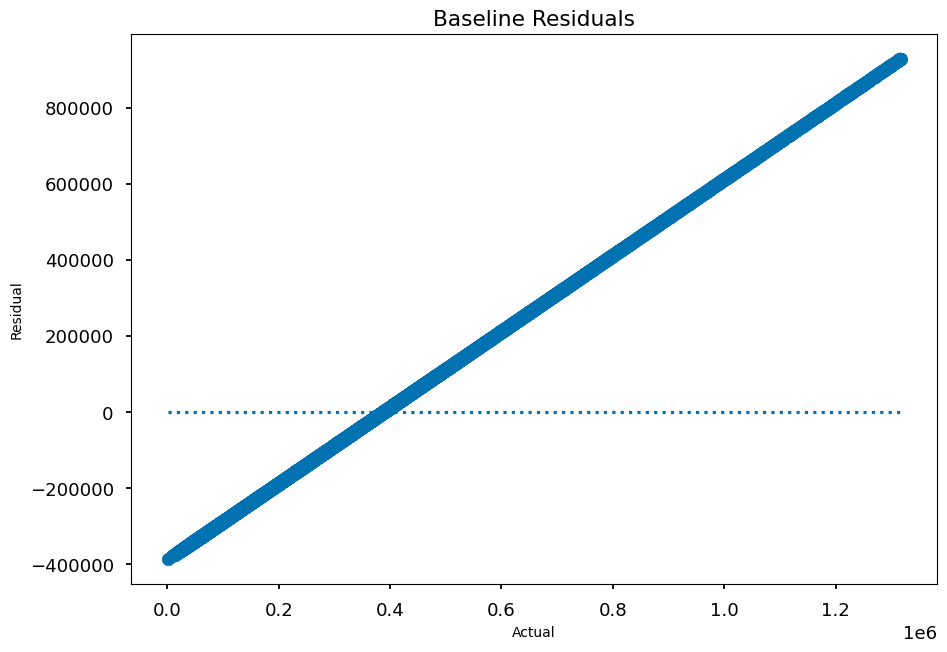

In [62]:
model.plot_residuals(y_train.tax_value, y_train.baseline_mean)


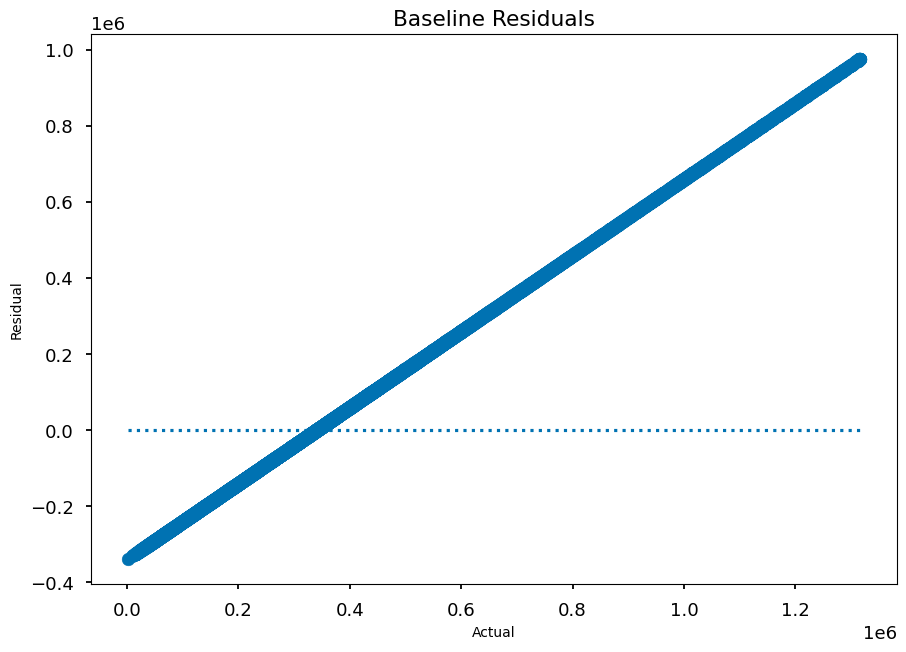

In [63]:
model.plot_residuals(y_train.tax_value, y_train.baseline_median)


In [64]:
#Evaluate the baseline model using the mean
model.baseline_mean_errors(y_train.tax_value)

{'sse': 2664792326603674.0,
 'mse': 65517476620.94446,
 'rmse': 255963.81896851058}

In [65]:
#Evaluate the baseline model using the median
model.baseline_median_errors(y_train.tax_value)

{'sse': 2756934504210152.0,
 'mse': 67782915059.37974,
 'rmse': 260351.52209921827}

In [66]:
# RMSE of pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  255963.82 
Validate/Out-of-Sample:  257222.1


In [67]:
#RMSE of pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Median
Train/In-Sample:  260351.52 
Validate/Out-of-Sample:  261943.44


In [78]:
#LinearRegression
lm = LinearRegression()
#fit the thing
#only fit on training
lm.fit(X_train, y_train.tax_value)
#use the thing
y_train['pred_lm'] = lm.predict(X_train)
y_train.head()

rmse_train_lm = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(0.5)
# predict validate
y_validate['pred_lm'] = lm.predict(X_validate)
# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(0.5)

In [79]:
#Lasso Lars
lars = LassoLars(alpha=1.0)
#fit the thing
lars.fit(X_train, y_train.tax_value)
#predict the thing: train
y_train['pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(0.5)
# predict the thing: validate
y_validate['pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(0.5)

In [80]:
#Tweedie Regressor
glm = TweedieRegressor(power=1, alpha=0)
#fit the thing 
glm.fit(X_train, y_train.tax_value)
#predict the thing: train
y_train['pred_glm'] = glm.predict(X_train)
# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.tax_value, y_train.pred_glm)**(0.5)
#predict the thing: validate
# predict validate
y_validate['pred_glm'] = glm.predict(X_validate)
# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.tax_value, y_validate.pred_glm)**(0.5)

In [81]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.tax_value, y_train.pred_lm2)**(0.5)

# predict validate
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2)**(0.5)

In [72]:
print(f'''
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 2)}
Validate/Out-of-Sample: {round(rmse_validate, 2)}
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: {round(rmse_train_lm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 2)}
------------------------------------
RMSE for LassoLars:

Training/In-Sample: {round(rmse_train_lars, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 2)}
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: {round(rmse_train_glm, 2)}
Validation/Out-of-Sample: {round(rmse_validate_glm, 2)}
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: {round(rmse_train_lm2, 2)}
Validation/Out-of-Sample: {round(rmse_validate_lm2, 2)}

''')


BASELINE:
              
RMSE using Median
Train/In-Sample: 260351.52
Validate/Out-of-Sample: 261943.44
------------------------------------
RMSE for OLS using LinearRegression:
    
Training/In-Sample: 212676.0
Validation/Out-of-Sample: 213730.37
------------------------------------
RMSE for LassoLars:

Training/In-Sample: 212671.61
Validation/Out-of-Sample: 213741.46
------------------------------------
RMSE for GLM using Tweedie, power=1 & alpha=0:

Training/In-Sample: 255963.82
Validation/Out-of-Sample: 257222.1
------------------------------------
RMSE for Polynomial Model, degrees=2:

Training/In-Sample: 200976.36
Validation/Out-of-Sample: 203874.82




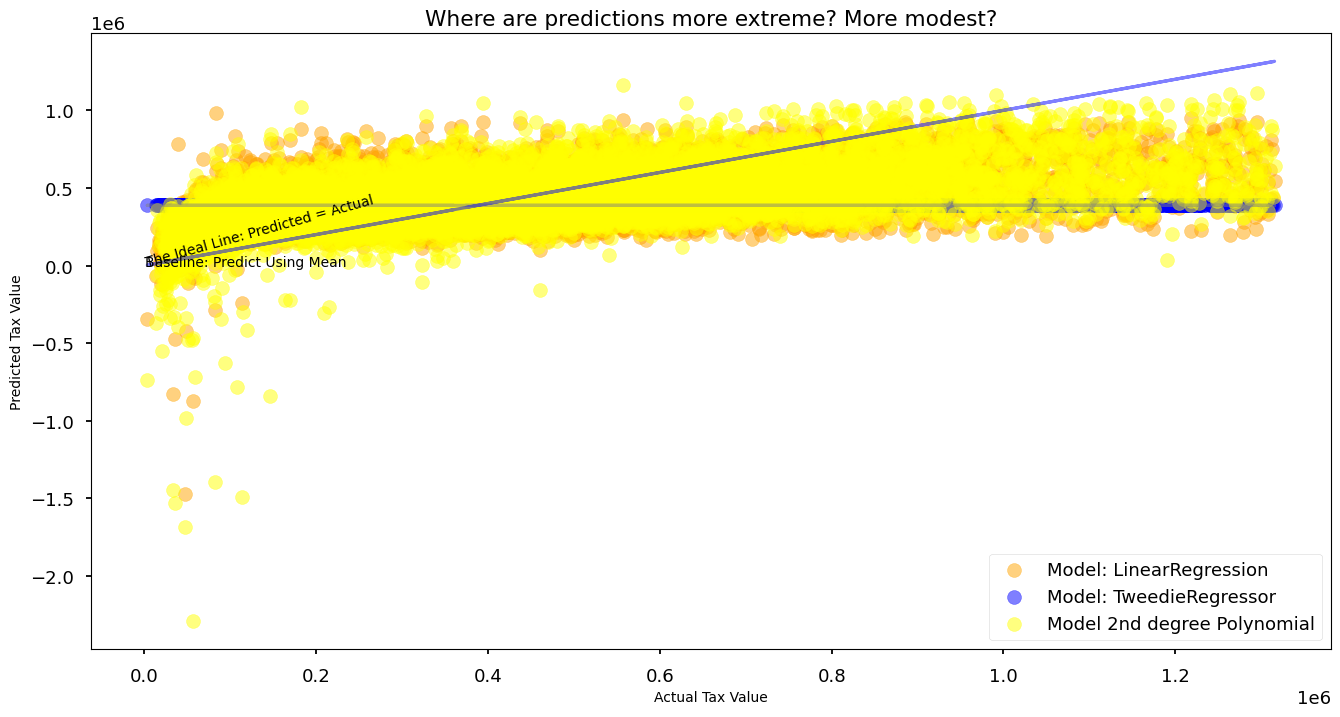

In [73]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
            alpha=.5, color="orange", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
            alpha=.5, color="blue", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.pred_lm2, 
            alpha=.5, color="yellow", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [74]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.baseline_mean)}])


metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm)}, ignore_index=True)


metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lars)}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'GLS (Poisson)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_glm)}, ignore_index=True)


metric_df = metric_df.append({
    'model': 'Quadratic Model', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.pred_lm2)}, ignore_index=True)

metric_df 

,model,RMSE_validate,r^2_validate
0,mean_baseline,261943.442150,2.220446e-16
1,OLS Regressor,213730.369311,3.095704e-01
2,Lasso alpha 1,213741.462475,3.095132e-01
3,GLS (Poisson),257222.102045,2.220446e-16
4,Quadratic Model,203874.816062,3.717769e-01


In [75]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm2)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
    
Test/Out-of-Sample Performance: {rmse_test}
""")



RMSE for Polynomial Regressor, degrees=2:
    
Test/Out-of-Sample Performance: 202864.84707069927



### Recommendation:   The Area tend to be the key driver, follow by 